In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import sys
from pathlib import Path
import os
import math
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.metrics import accuracy_score

In [22]:
#Data constants
shapes_B = [2, 4]#[2, 2]
scales_B = [3, 3]
k_B = len(scales_B) # Number of classes
d_B = 2 # Number of dimensions
p_c_B = [1/len(shapes_B)]*len(shapes_B) # Uniform distributon over classes
tag_B = f'k_{k_B}_d{d_B}_shapes{shapes_B}_scales{scales_B}_pc{p_c_B}'.replace(" ", "")

shapes_A = [2, 6]#[2, 2]
scales_A = [5, 3]
k_A = len(scales_A) # Number of classes
d_A = 2 # Number of dimensions
p_c_A = [1/len(shapes_A)]*len(shapes_A) # Uniform distributon over classes
tag_A = f'k_{k_A}_d{d_A}_shapes{shapes_A}_scales{scales_A}_pc{p_c_A}'.replace(" ", "")

In [23]:
val_data_A = test_data_A = pd.read_csv(f"data/val_n_5000_{tag_A}.csv")
# Expected accuracy on any test set sampled from this distribution
exp_acc_A = np.sum(val_data_A[[f"p_c{i}_given_r" for i in range(k_B)]].max(axis=1))/len(val_data_A)
# But in our case, we will see the actual accuracy on this test set compared to expectation
val_data_A["Expected class"] = np.array(val_data_A[[f"p_c{i}_given_r" for i in range(k_A)]]).argmax(axis=-1)
max_acc_A = accuracy_score(val_data_A["class"], val_data_A["Expected class"], normalize=True)

print(f"Expected accuray: {exp_acc_A}, Max optimal accuracy validation set: {max_acc_A}")

Expected accuray: 0.7392684512065718, Max optimal accuracy validation set: 0.7382


In [24]:
def plot_hyperparams(dfs, model_names, n_data, hyperparams, metric_key, ymin=0, ymax=1, max_acc=1):
    
    for j in range(len(model_names)):
        for ntrain in n_data:
            fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(7, 2),  layout="constrained")
            df = dfs[j][dfs[j]["ntrain"] == ntrain]
            i = 0
            for value in hyperparams["lr"]:
                df_subset = df[df["lr"] == value]
                sn.barplot(df_subset, x="weight_decay", y=metric_key, hue="layers", ax=axs[i])
                axs[i].set_title(f"lr = {value}", fontsize=10)
                if metric_key == "ACC":
                    axs[i].set_ylim(0.4, 0.8)
                    axs[i].set_yticks([0.4, 0.5, 0.6, 0.7, 0.8])
                    x = [0, 2.5]
                    y = [max_acc, max_acc]
                    axs[i].plot(x, y, c="green", label=f"Max")
                else:
                    axs[i].set_ylim(ymin, ymax)
                i = i + 1
            handles, labels = axs[0].get_legend_handles_labels()
            labels = [f"layers={item}" for item in labels]
            if metric_key == "ACC":
                labels[-1] = "OptACC"
            fig.suptitle(f"{model_names[j]}, ntrain={ntrain}", x=0.1, va="top", fontsize=16)
            fig.legend(handles, labels, loc='upper right', ncol=4, labelspacing=0.1, fontsize=10)
            for ax in axs:
                ax.get_legend().remove()
                ax.grid(True)

In [59]:
def plot_model_hyperparams(dfs, model_names, hyperparams, model_hyperpam, model_hyperpam_values, 
                           metric_key, ylabel, ymin=0, ymax=1, max_acc=1):
    for j in range(len(model_names)):
        fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(7, 2),  layout="constrained")
        df = dfs[j]
        i = 0
        for value in model_hyperpam_values[j]:
            df_subset = df[df[model_hyperpam[j]] == value]
            if model_names[j] == "NNE":
                axs[i].set_title(f"{model_hyperpam[j]} = {value}", fontsize=10)
            else:
                df_subset = df_subset[df_subset["lr"] == 0.001]
                axs[i].set_title(f"{model_hyperpam[j]} = {value}", fontsize=10)
                
            sn.barplot(df_subset, x="ntrain", y=metric_key, hue="layers", ax=axs[i])
            axs[i].set_ylim(ymin, ymax)
            axs[i].set_ylabel(ylabel)
                        
            if metric_key == "ACC":
                axs[i].set_ylim(0.4, 0.8)
                axs[i].set_yticks([0.4, 0.5, 0.6, 0.7, 0.8])
                x = [0, 2.5]
                y = [max_acc, max_acc]
                axs[i].plot(x, y, c="green", label=f"Max")
            i = i + 1
        handles, labels = axs[0].get_legend_handles_labels()
        labels = [f"layers={item}" for item in labels]
        if metric_key == "ACC":
            labels[-1] = "OptACC"
        if model_names[j] == "NNE":
            fig.suptitle(f"{model_names[j]}", x=0.1, va="top", fontsize=16)
        else:
            fig.suptitle(f"{model_names[j]}, lr=0.001", x=0.1, va="top", fontsize=16)
        fig.legend(handles, labels, loc='upper right', ncol=4, labelspacing=0.1, fontsize=10)
        for ax in axs:
            if ax.get_legend() != None:
                ax.get_legend().remove()
            ax.grid(True)

In [26]:
def load_df(folder_path, n_runs, n_data):
    #filenames = [[f"{folder_path}/results_run{i}_ntrain{n}.csv" for i in range(n_runs)] for n in ntrain]
    filenames = [
    f"{folder_path}/results_run{i}_ntrain_{n}.csv"
    for i in range(n_runs)
    for n in n_data
    ]
    df = pd.concat((pd.read_csv(f) for f in filenames), ignore_index=True)
    return df

model_names = ["NNE", 
               "CL",
               "EDL",
               "MCD"]

folder_names = ["ensemble", "CL", "evidential", "MCD"]
folder_paths_A = [f"DNN/gridsearch/train_n_50000_{tag_A}/{folder}" for folder in folder_names]
n_models = len(model_names)
n_data = [250, 1000, 5000]
n_runs = [1, 1, 20, 20]

dfs_A = [load_df(folder_paths_A[i], n_runs[i], n_data) for i in range(n_models)]

In [42]:
hyperparams = {
        "lr" : [0.01, 0.001, 0.0001],
        "weight_decay" : [0.1, 0.01, 0.001],
        "layers" : [1, 3, 8]
    }
metric_keys = ["ACC", "LogLoss", "Mean KL-div", "WD", "Mean UQ", "Std UQ",
                    "Mean Pc1 OOD", "Std Pc1 OOD",
                    "Mean UQ OOD", "Std UQ OOD"]

model_hyperpam = ["lr",
                  "bias_weight",
                  "annealing_coef",
                  "p_dropout"
                  ]
model_hyperpam_values = [[0.01, 0.001, 0.0001],
                         [0.5, 0.2, 0.1],
                         [0.0002, 0.002, 0.02],
                         [0.1, 0.3, 0.5]
                        ]


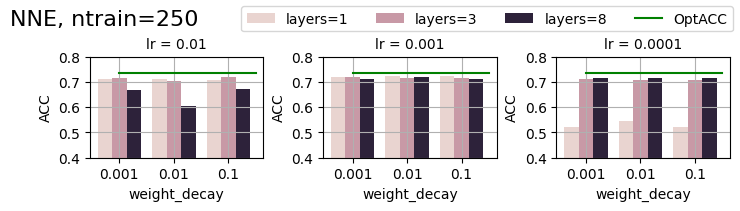

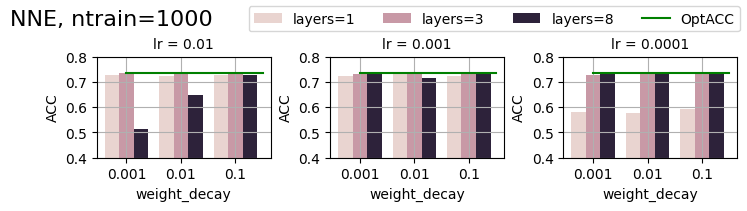

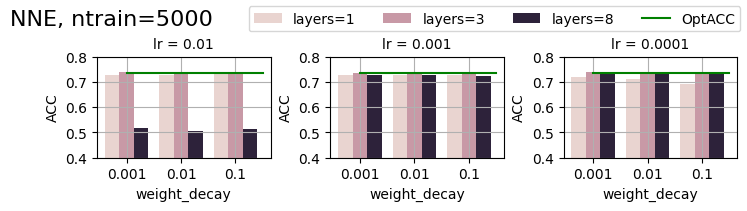

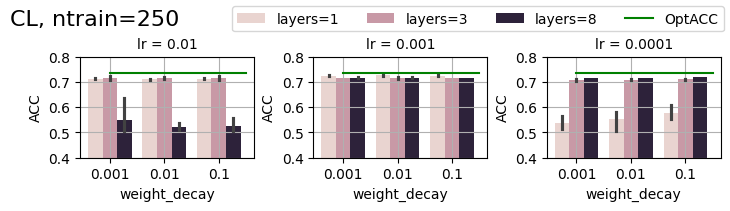

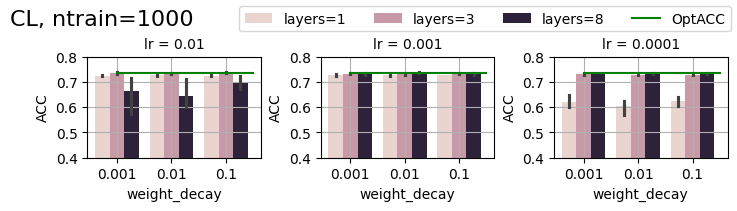

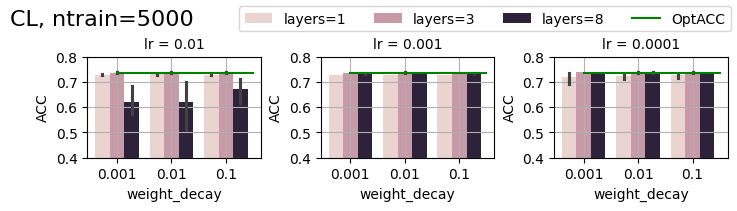

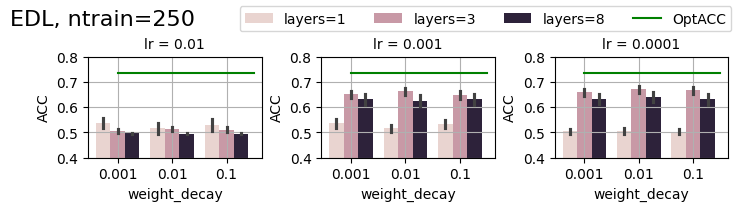

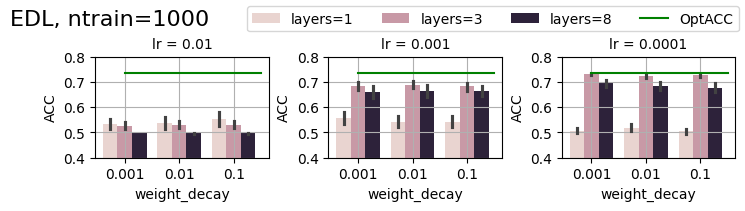

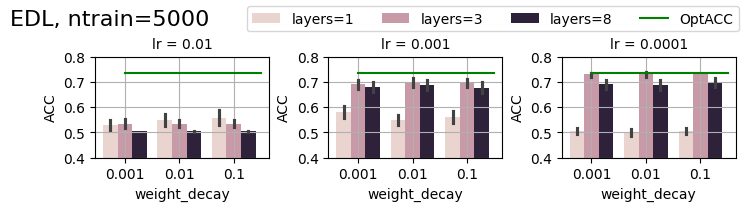

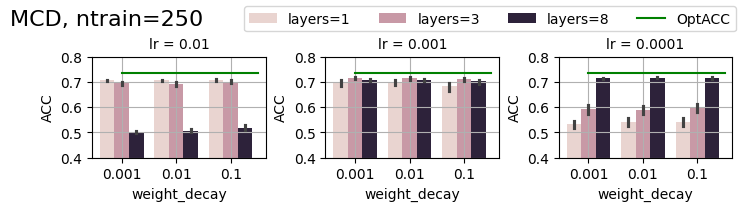

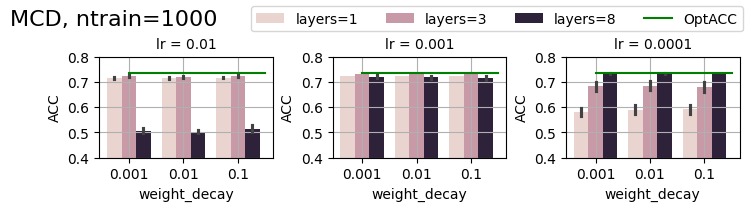

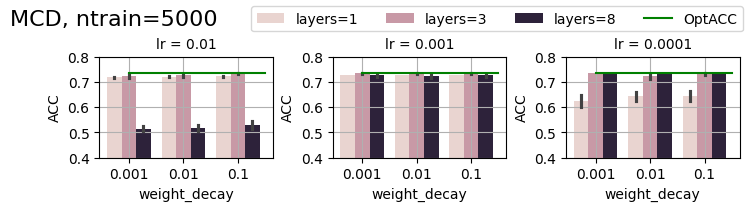

In [28]:
plot_hyperparams(dfs_A, model_names, n_data, hyperparams, "ACC", ymin=0.4, ymax=0.1, max_acc=max_acc_A)

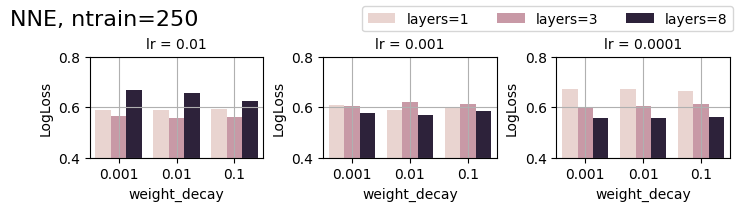

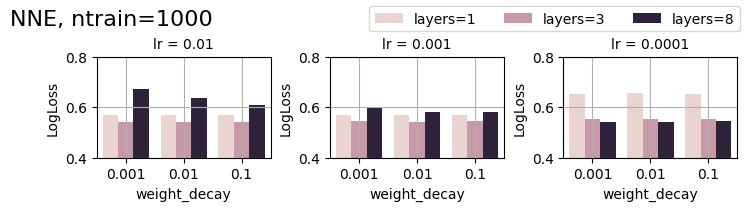

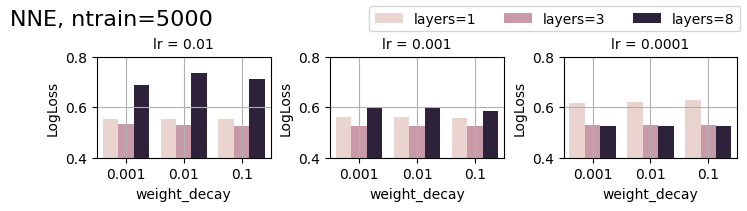

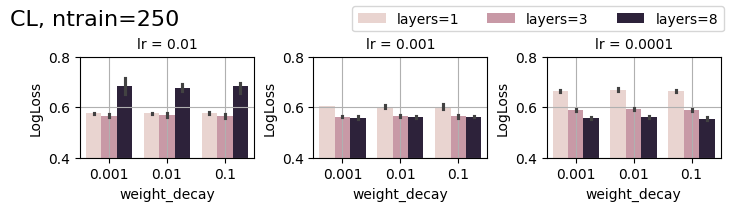

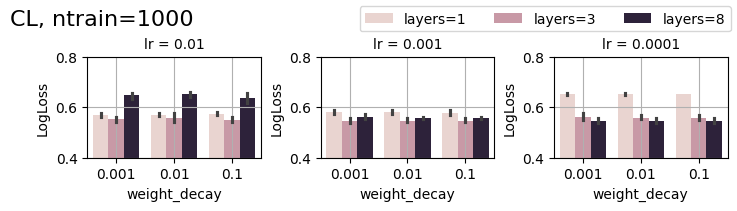

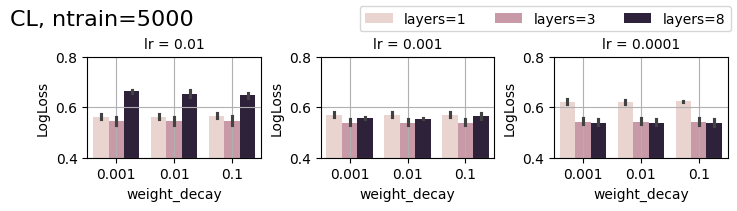

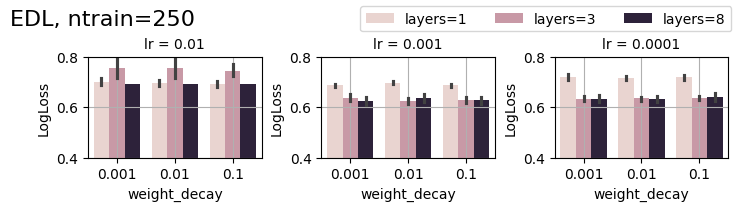

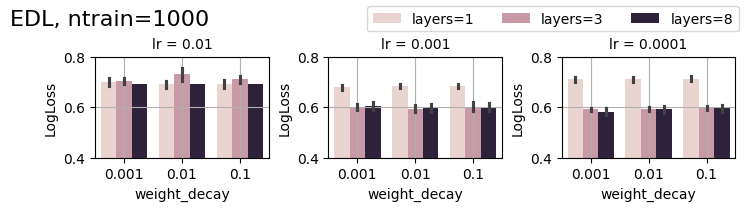

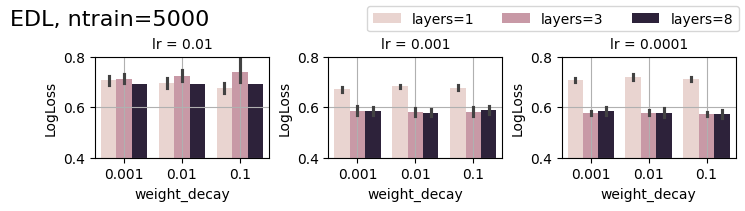

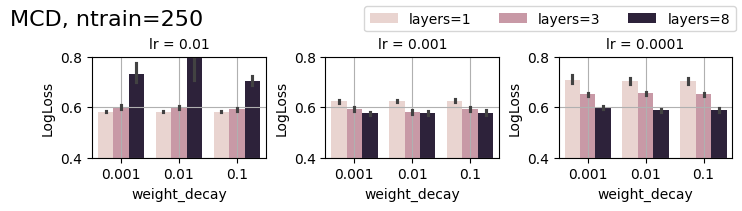

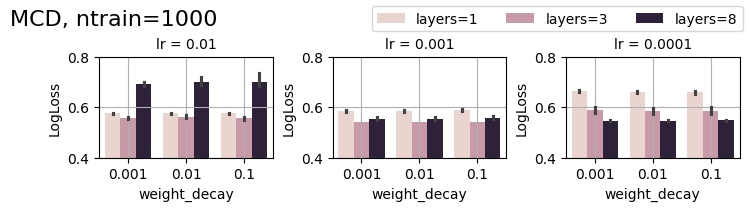

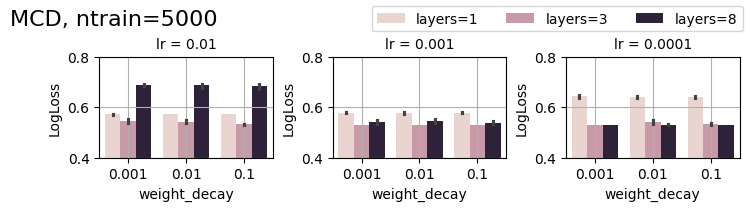

In [29]:
plot_hyperparams(dfs_A, model_names, n_data, hyperparams, "LogLoss", ymin=0.4, ymax=0.8)

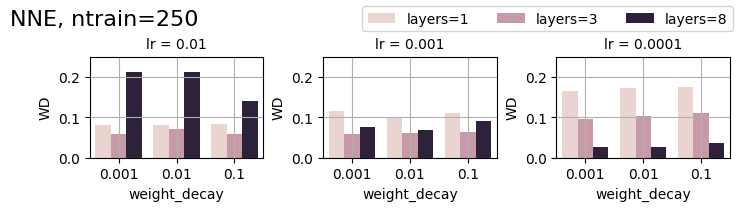

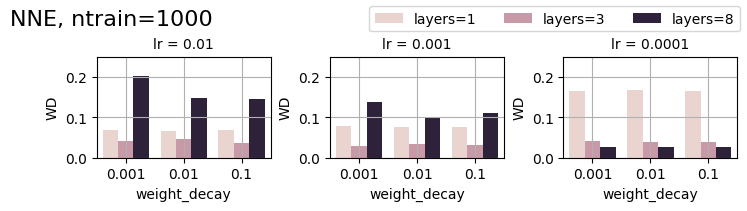

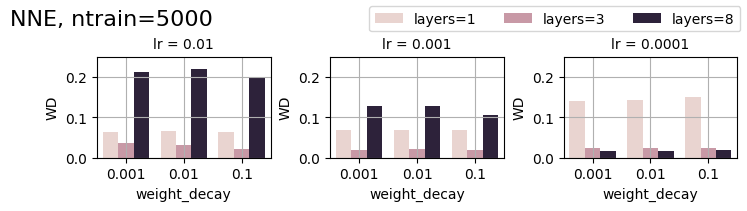

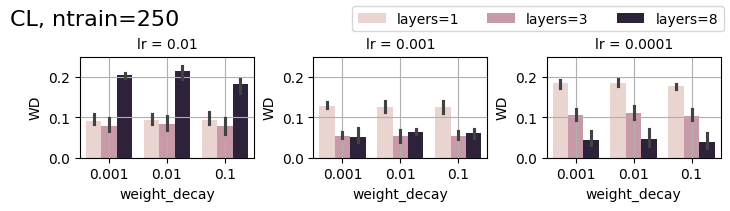

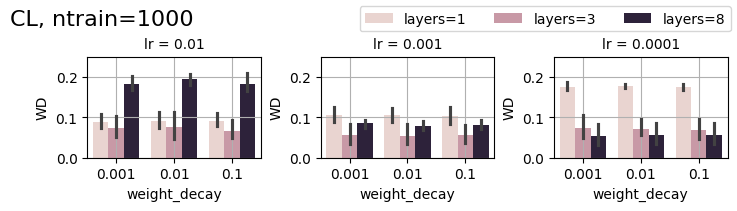

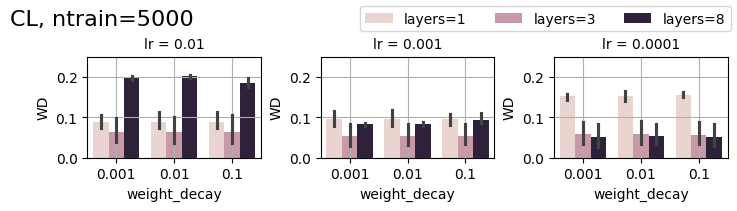

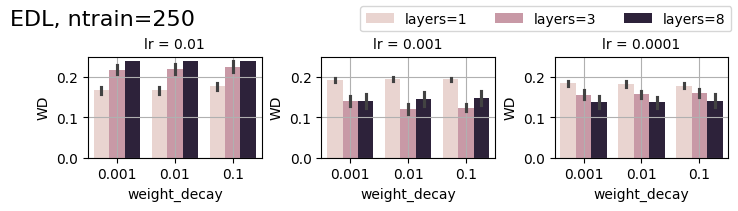

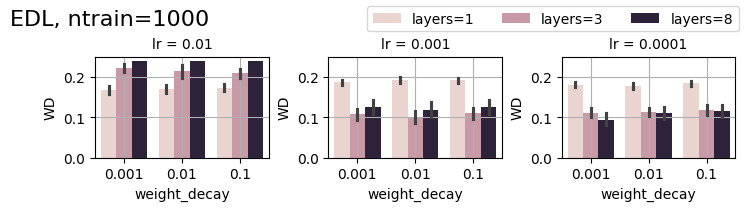

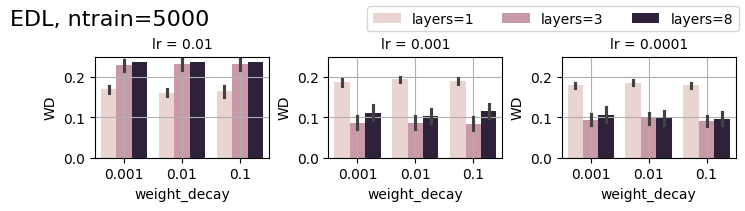

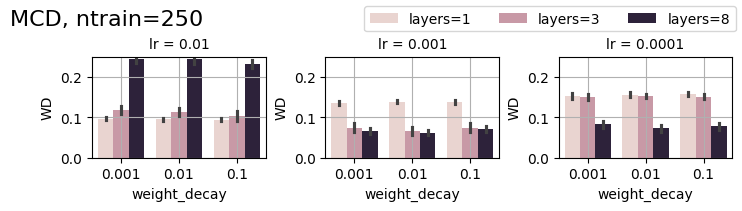

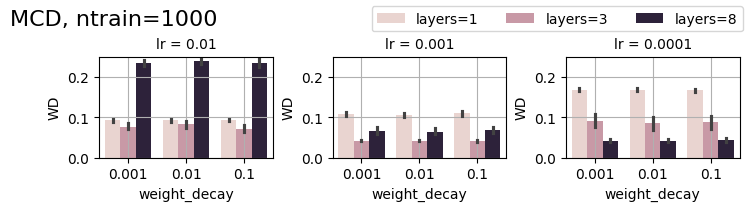

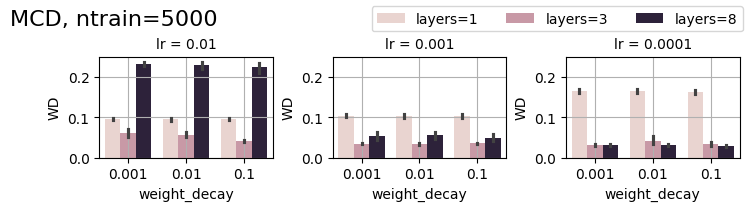

In [30]:
plot_hyperparams(dfs_A, model_names, n_data, hyperparams, "WD", ymin=0, ymax=0.25)

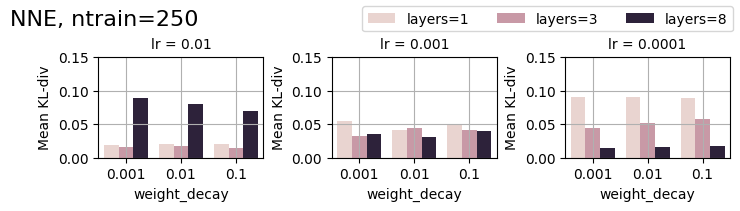

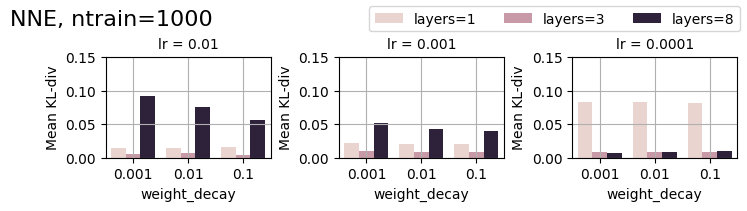

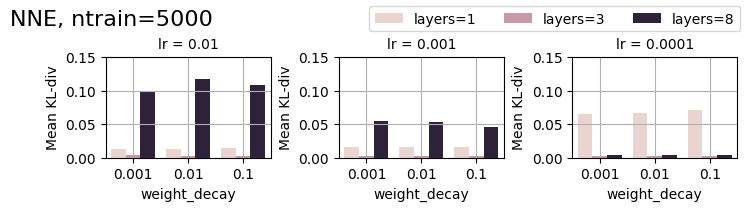

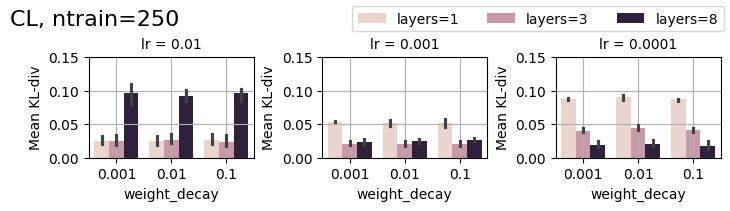

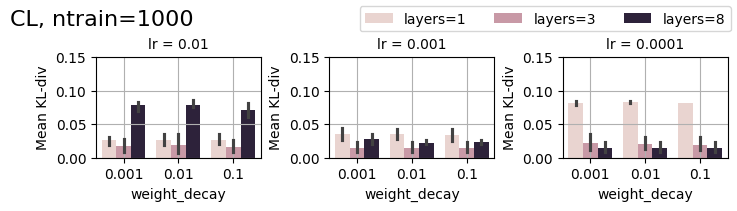

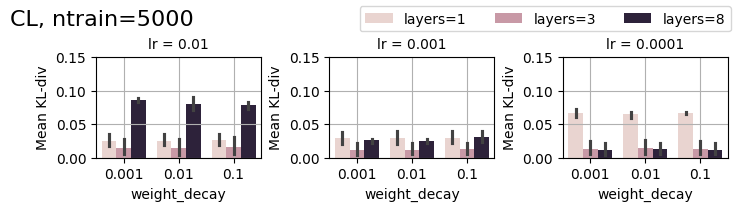

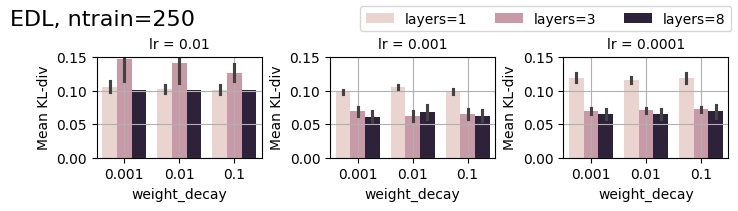

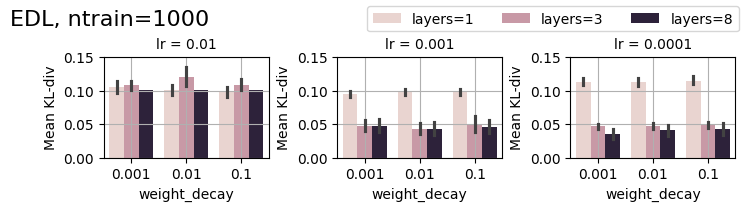

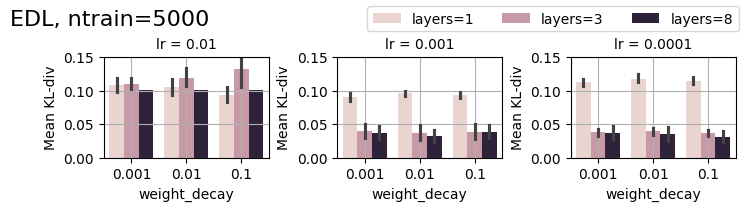

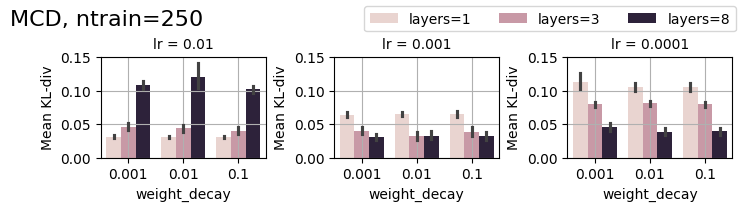

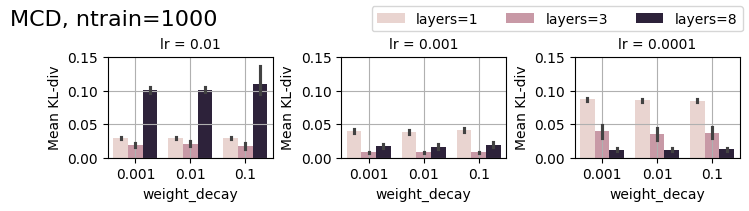

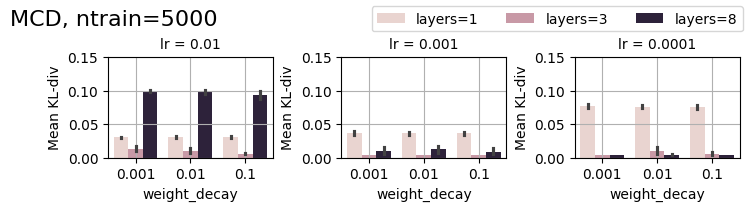

In [31]:
plot_hyperparams(dfs_A, model_names, n_data, hyperparams, "Mean KL-div", ymin=0, ymax=0.15)


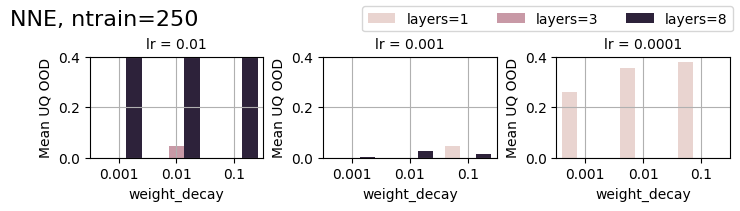

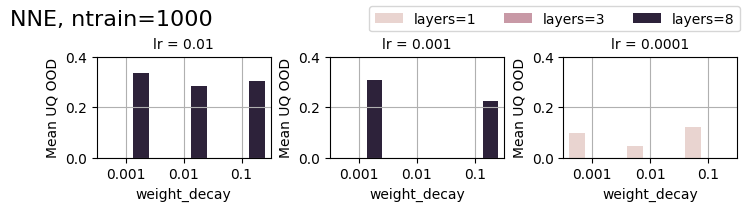

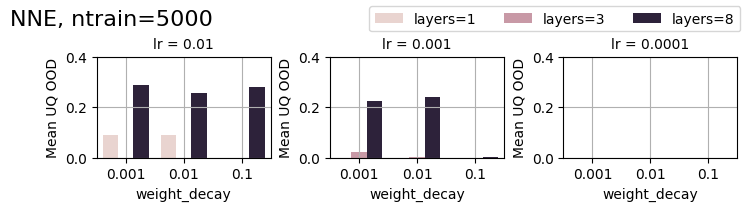

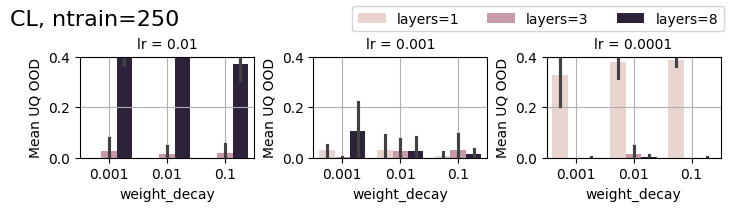

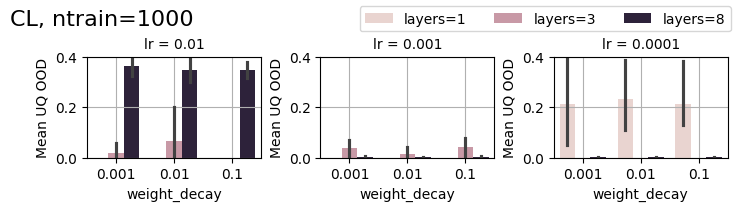

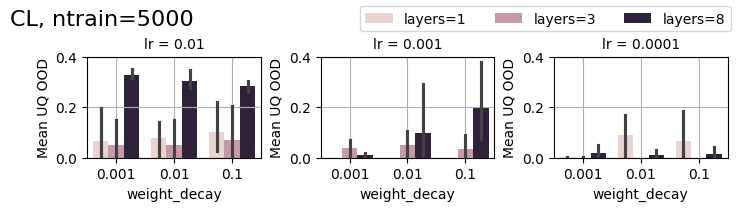

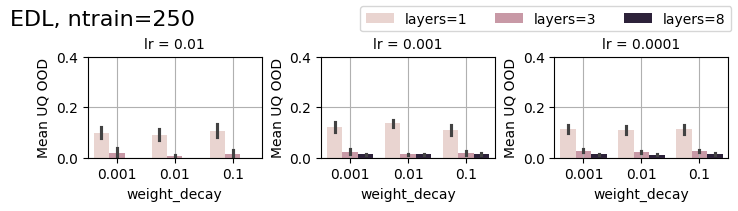

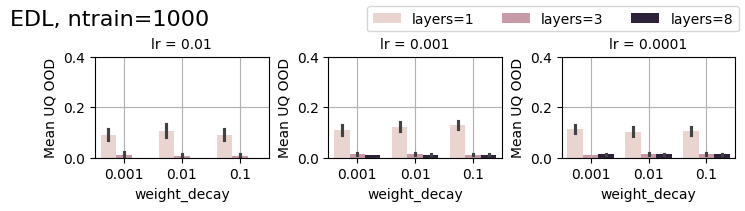

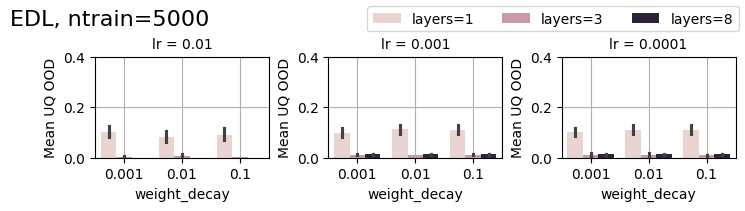

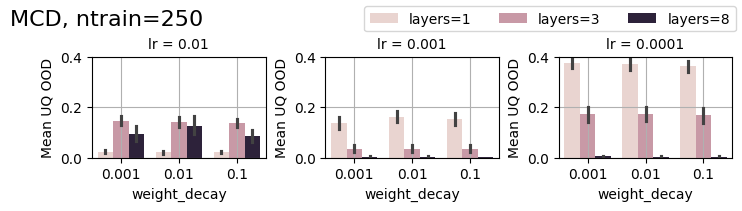

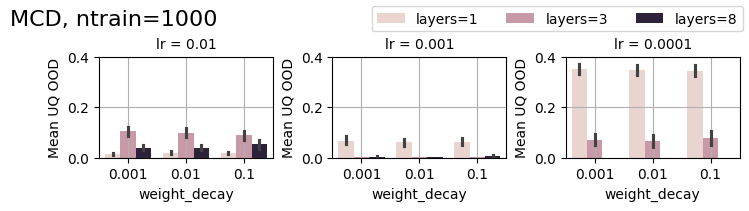

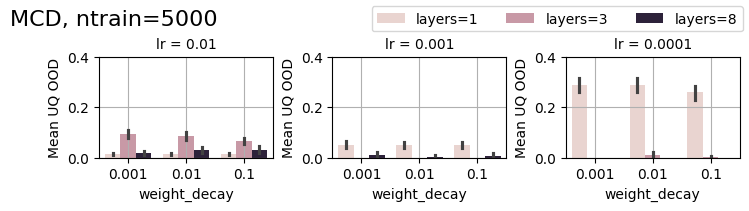

In [32]:
plot_hyperparams(dfs_A, model_names, n_data, hyperparams, "Mean UQ OOD", ymin=0, ymax=0.4)


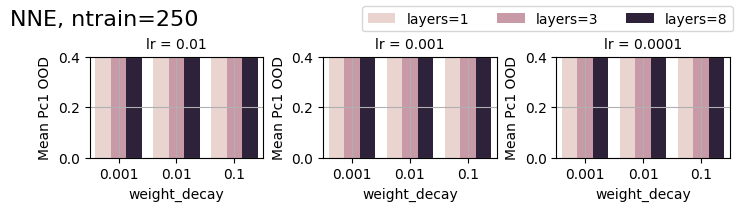

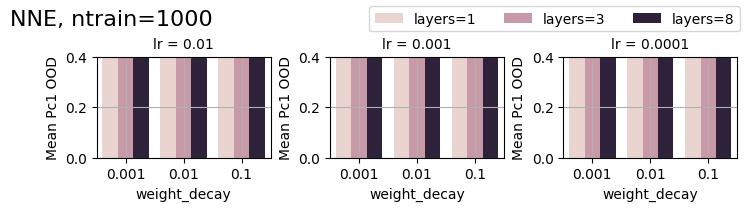

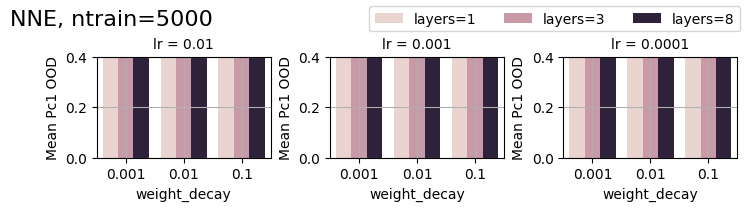

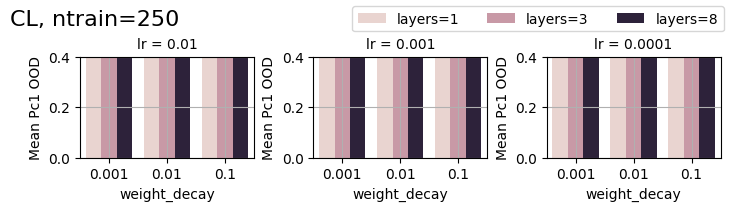

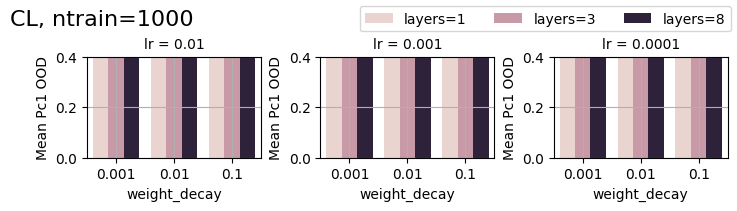

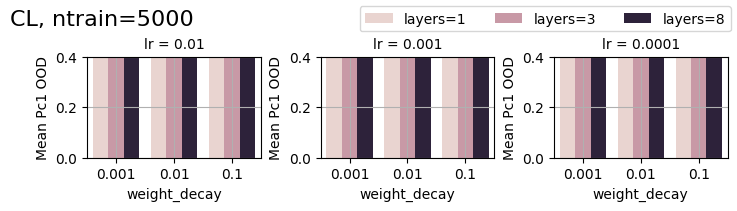

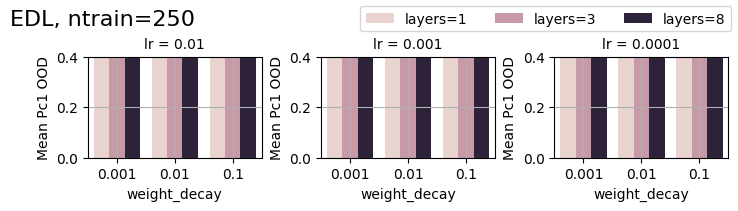

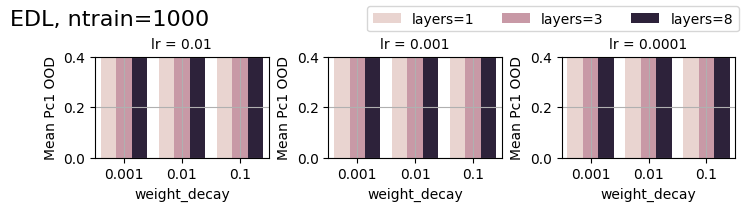

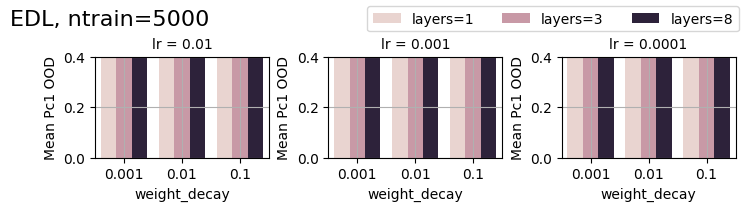

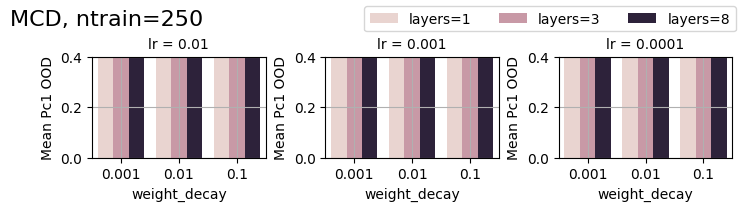

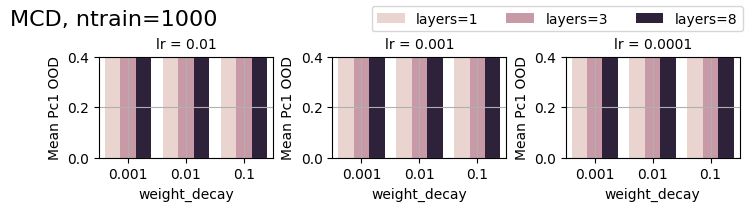

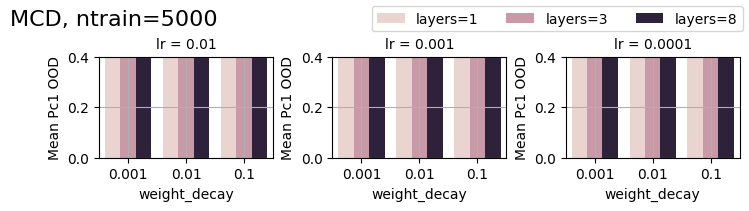

In [64]:
plot_hyperparams(dfs_A, model_names, n_data, hyperparams, "Mean Pc1 OOD", ymin=0, ymax=0.4)


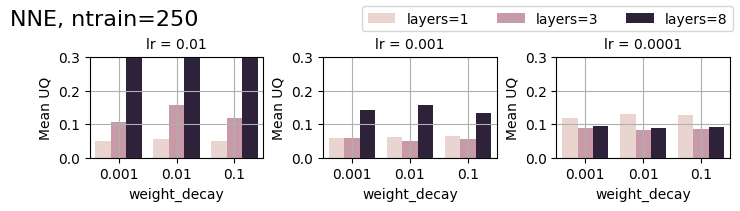

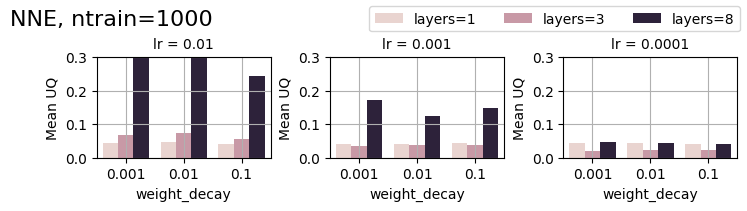

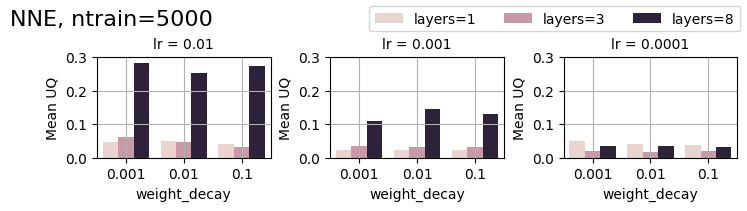

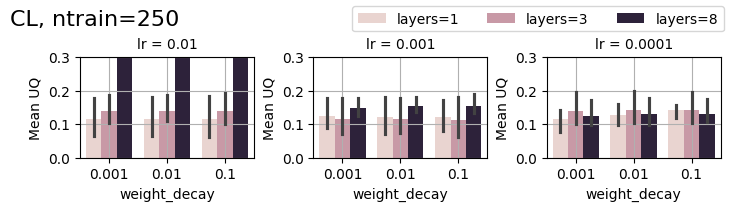

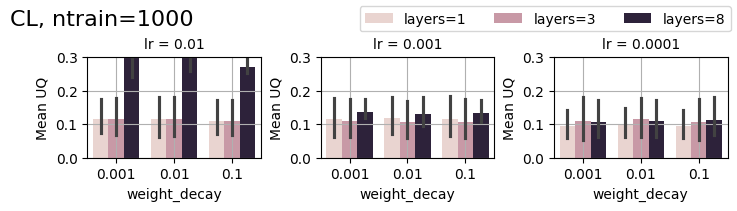

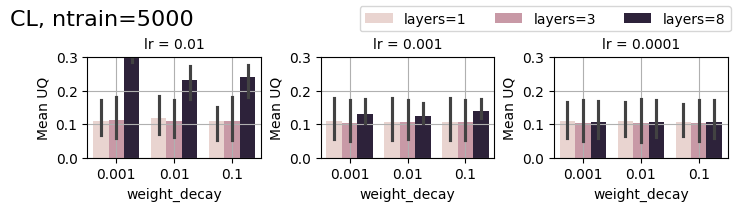

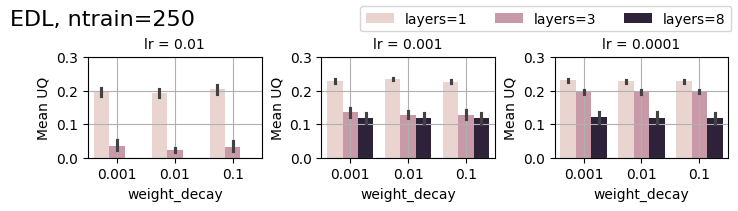

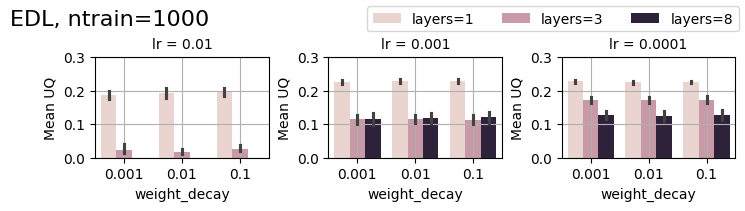

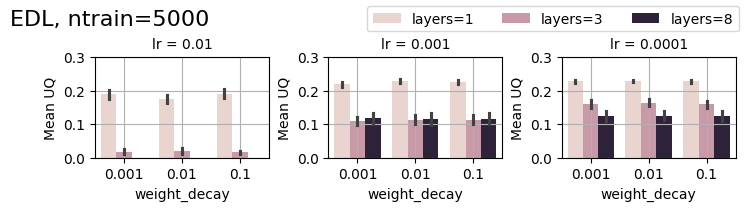

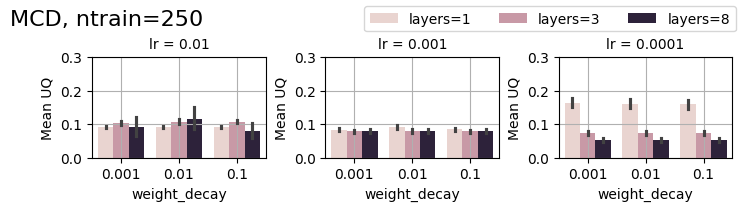

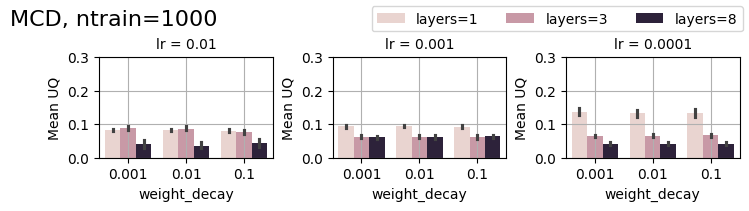

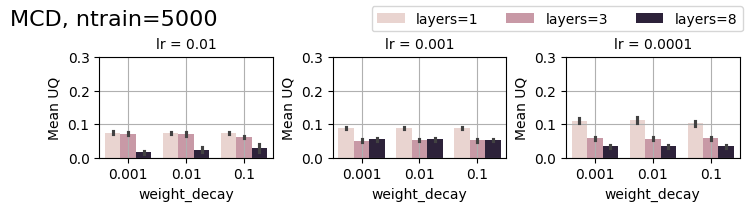

In [33]:
plot_hyperparams(dfs_A, model_names, n_data, hyperparams, "Mean UQ", ymin=0, ymax=0.3)


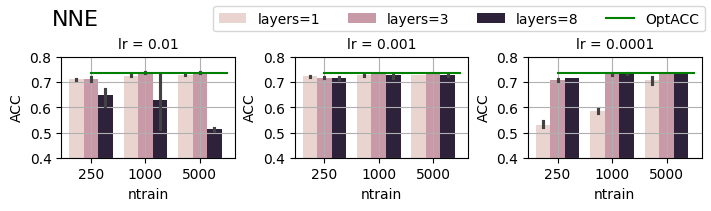

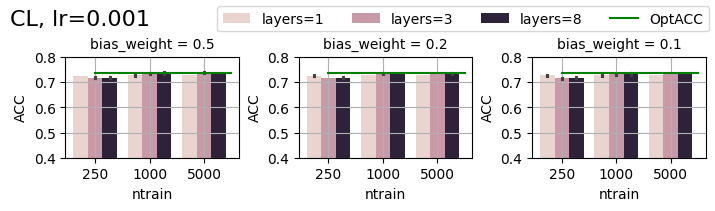

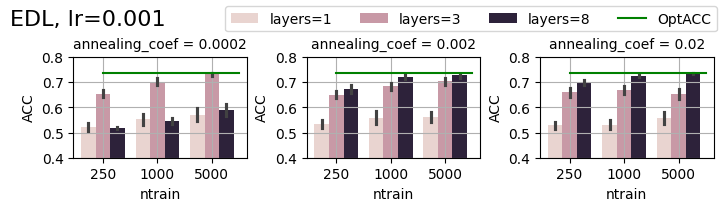

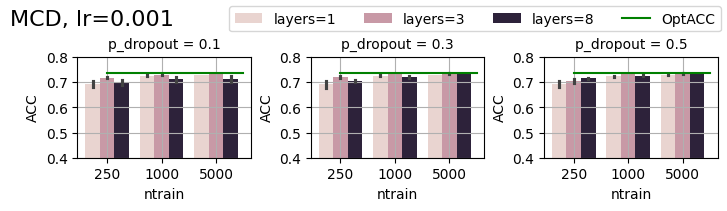

In [51]:
plot_model_hyperparams(dfs_A, model_names, hyperparams, model_hyperpam, model_hyperpam_values, "ACC", "ACC", 0.4, 0.8, max_acc=max_acc_A)


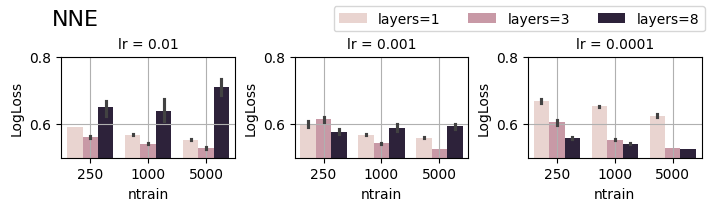

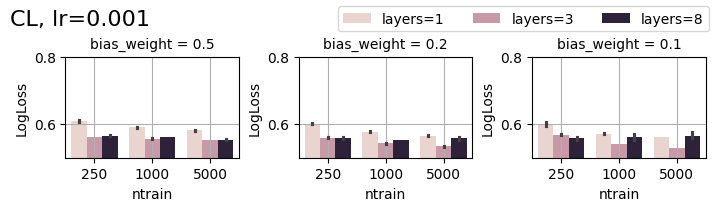

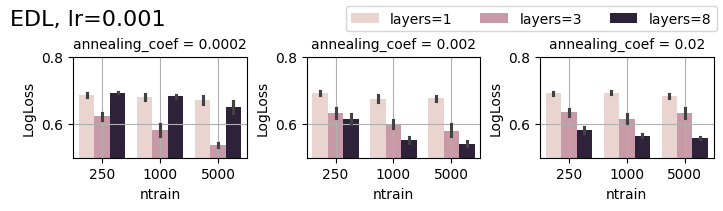

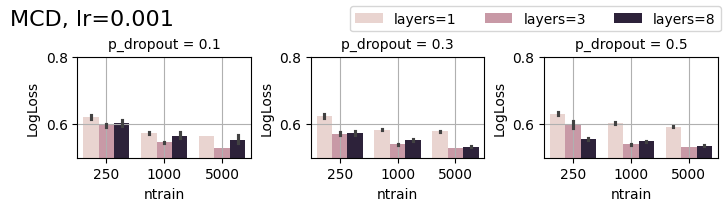

In [52]:
plot_model_hyperparams(dfs_A, model_names, hyperparams, model_hyperpam, model_hyperpam_values, "LogLoss", "LogLoss", 0.5, 0.8)


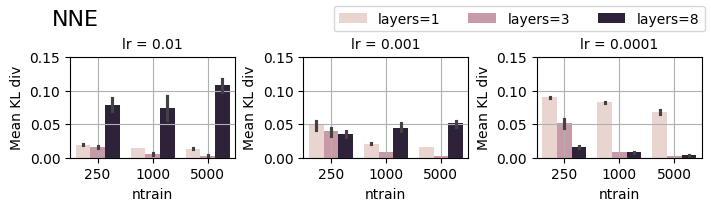

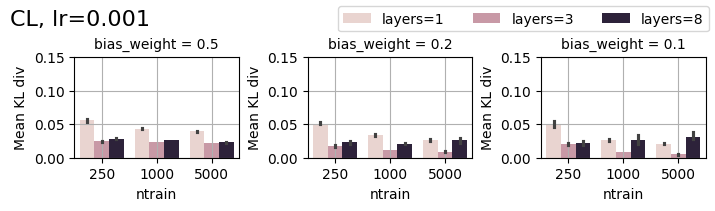

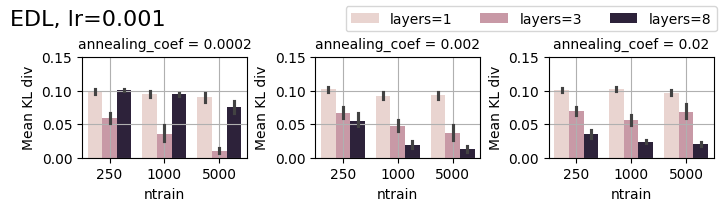

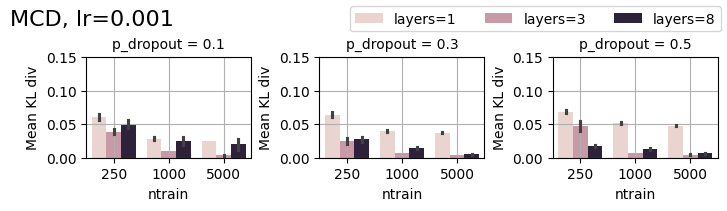

In [63]:
plot_model_hyperparams(dfs_A, model_names, hyperparams, model_hyperpam, model_hyperpam_values, "Mean KL-div", "Mean KL div", 0, 0.15)


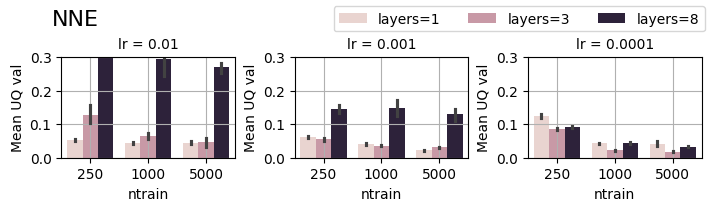

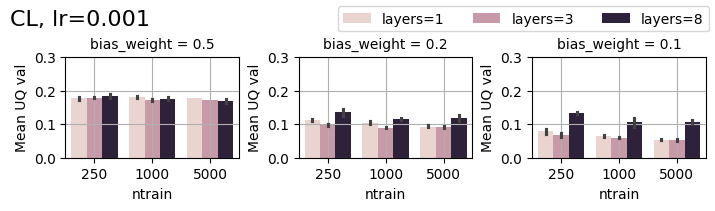

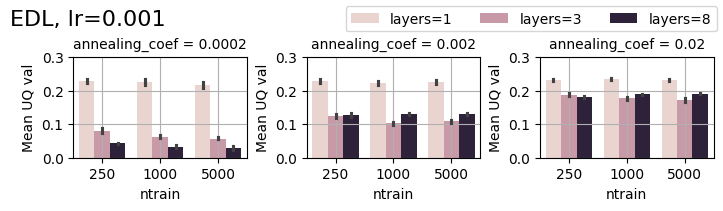

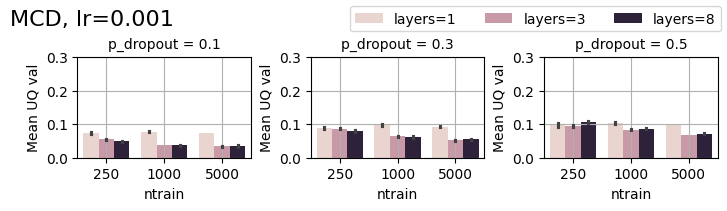

In [53]:
plot_model_hyperparams(dfs_A, model_names, hyperparams, model_hyperpam, model_hyperpam_values, "Mean UQ", "Mean UQ val", 0, 0.3)


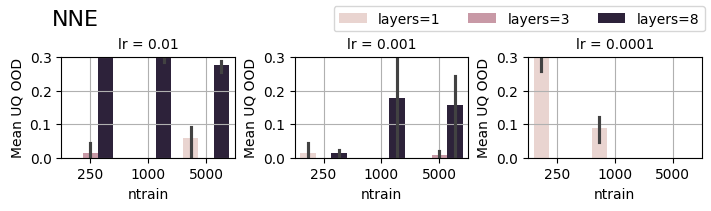

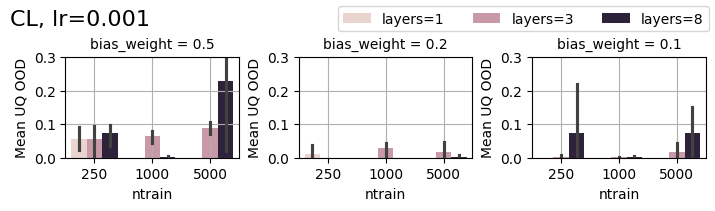

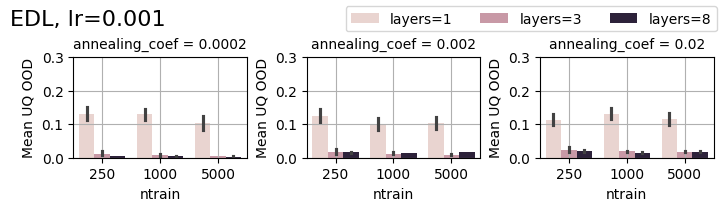

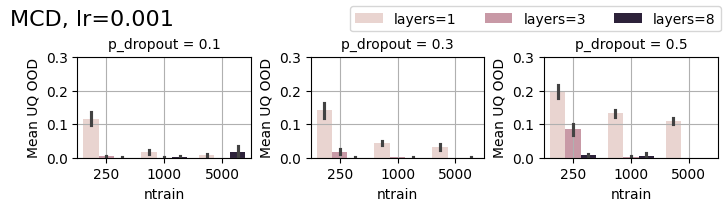

In [54]:
plot_model_hyperparams(dfs_A, model_names, hyperparams, model_hyperpam, model_hyperpam_values, "Mean UQ OOD", "Mean UQ OOD", 0, 0.3)


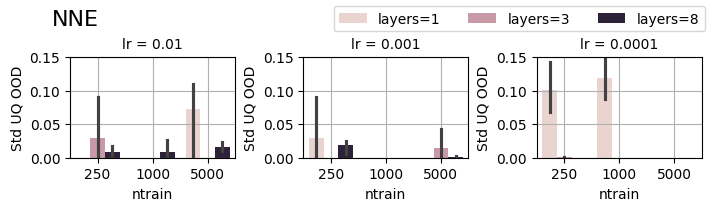

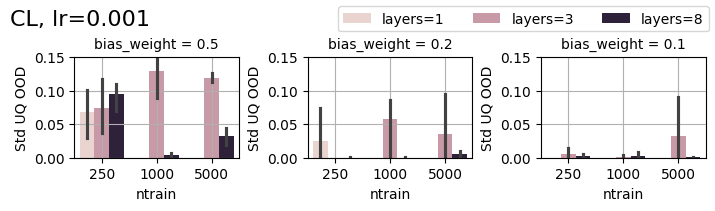

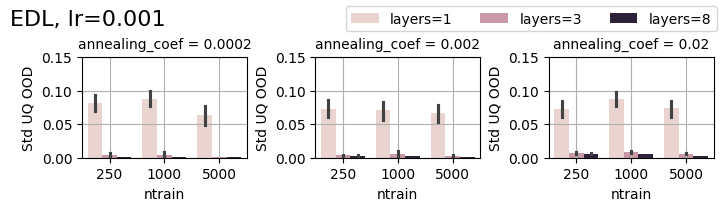

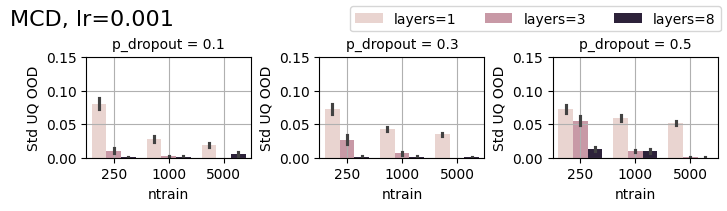

In [55]:
plot_model_hyperparams(dfs_A, model_names, hyperparams, model_hyperpam, model_hyperpam_values, "Std UQ OOD", "Std UQ OOD", 0, 0.15)

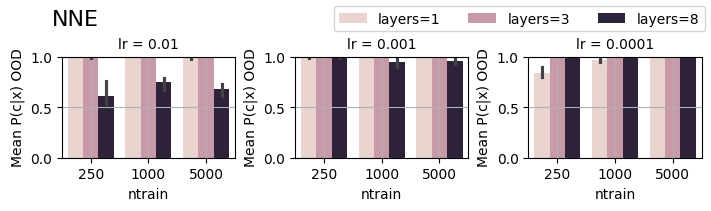

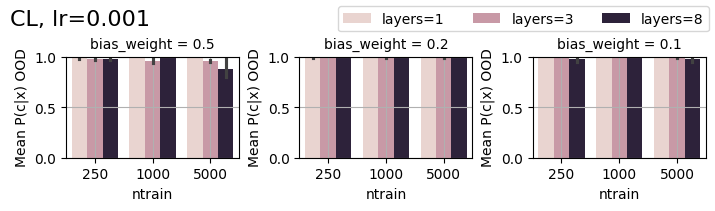

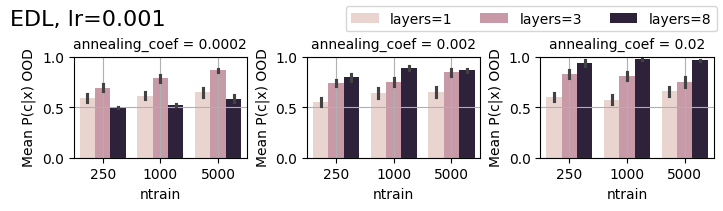

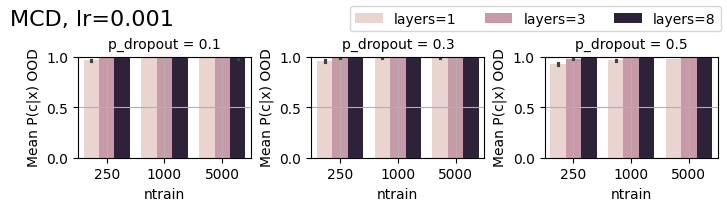

In [56]:
plot_model_hyperparams(dfs_A, model_names, hyperparams, model_hyperpam, model_hyperpam_values, "Mean Pc1 OOD", "Mean P(c|x) OOD", 0, 1)

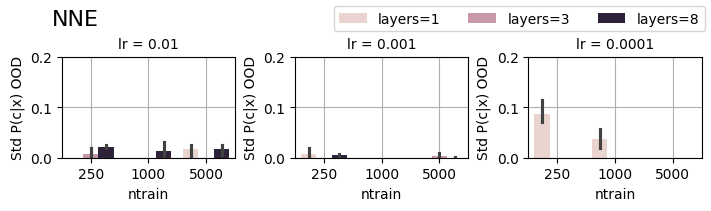

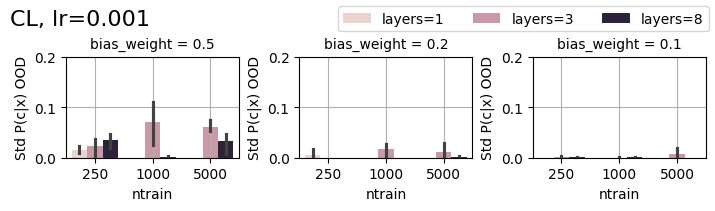

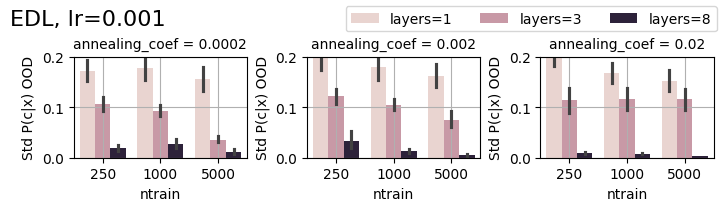

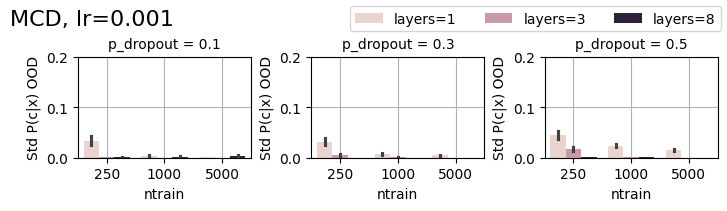

In [57]:
plot_model_hyperparams(dfs_A, model_names, hyperparams, model_hyperpam, model_hyperpam_values, "Std Pc1 OOD", "Std P(c|x) OOD", 0, 0.2)